In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
import edhek_risk_kit as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [7]:
from scipy.optimize import minimize

def msr(riskfree_rate: float, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }

    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol
    
    weights = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


In [17]:
l = ["Smoke", "Fin", "Games", "Coal"]
l = [v for v in er.index]
rf = 0.03
w = msr(0.03, er[l], cov.loc[l, l])
print("Weights: ", w)
p_ret = erk.portfolio_return(w, er[l])
print("Return: ", p_ret)
p_vol = erk.portfolio_vol(w, cov.loc[l,l])
print("Vol: ", p_vol)
print("Sharpe: ", (p_ret - rf)/p_vol)

Weights:  [2.02597207e-15 0.00000000e+00 3.91029455e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13705892e-01
 9.37668335e-17 3.08875014e-15 9.01466128e-16 0.00000000e+00
 6.33841575e-16 6.44243560e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.22910254e-02 1.88508863e-15 3.10624147e-01
 0.00000000e+00 0.00000000e+00 6.98564274e-02 1.07861776e-15
 0.00000000e+00 0.00000000e+00 1.69098152e-01 2.95725252e-17
 0.00000000e+00 1.69108766e-15]
Return:  0.22426515078671955
Vol:  0.0361234948745742
Sharpe:  5.377806091609774


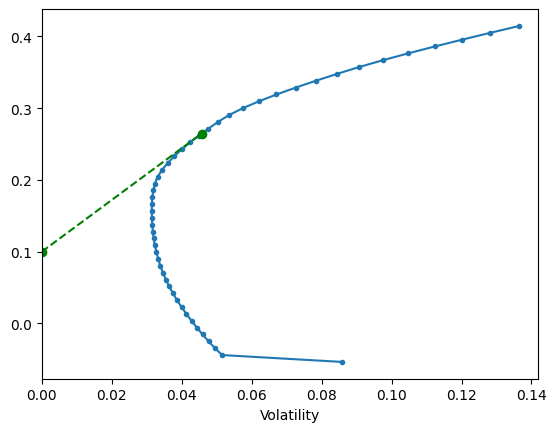

In [24]:
ax = erk.plot_ef(50, er, cov)
ax.set_xlim(left=0)
rf = 0.1
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# Add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color="green", marker="o", linestyle="dashed")

<Axes: xlabel='Volatility'>

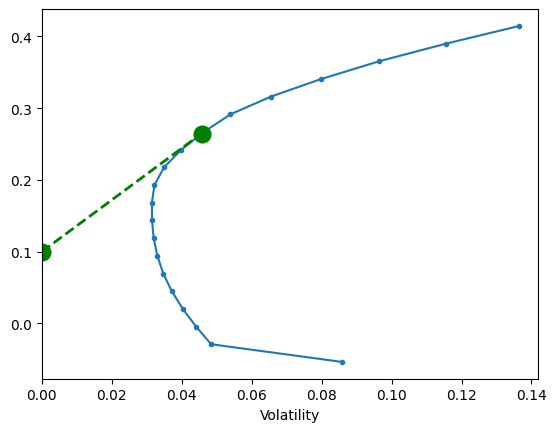

In [30]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1)